In [3]:
%matplotlib inline

In [77]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np

In [78]:
data = np.loadtxt("./examples/TB3MS.csv", skiprows=1, delimiter=",", usecols=[1])
r = np.loadtxt("./examples/treasury_bill_output_r.txt")
change_points = np.loadtxt("./examples/treasury_bill_output_change_points.txt")

In [85]:
ax.legend?

Text(0, 0.5, 'MAP')

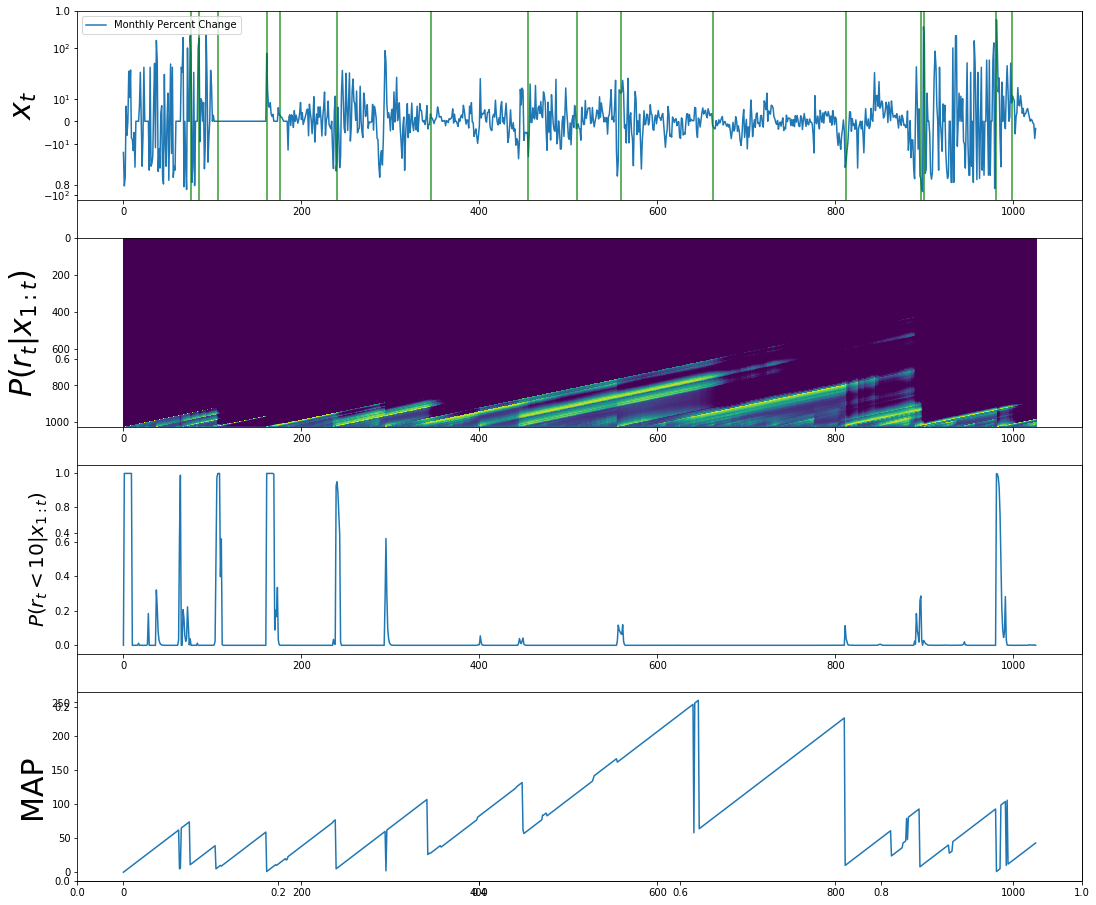

In [83]:
fig, ax = plt.subplots(figsize=[18, 16])

ax = fig.add_subplot(4, 1, 1)
ax.plot(data, label="Monthly Percent Change")
ax.set_yscale('symlog', linthreshy=20)
ax.set_ylabel("$x_t$", fontsize=30)
for change_point in change_points:
    line = ax.axvline(change_point, color="green", alpha=0.8)
line.set_
ax.legend()

    
ax = fig.add_subplot(4, 1, 2, sharex=ax)
ax.imshow(
    -np.log(np.rot90(r + 1E-10, 1)),
    cmap=cm.viridis_r,
    aspect="auto",
)
ax.set_ylabel("$P(r_t|x_{1:t})$", fontsize=30)

ax = fig.add_subplot(4, 1, 3, sharex=ax)
w = 10
ax.plot(np.sum(r[:, 1:w], axis=1))
ax.set_ylabel(f"$P(r_t < {w}|x_{{1:t}})$", fontsize=20)

ax = fig.add_subplot(4, 1, 4, sharex=ax)
ax.plot(np.argmax(r, axis=1))
ax.set_ylabel("MAP", fontsize=30)